In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json

import lightgbm as lgb
from sklearn.model_selection import GroupKFold

print("Lightgbm version:", lgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 281
Categorical features: 6


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 281
Categorical Columns: 6


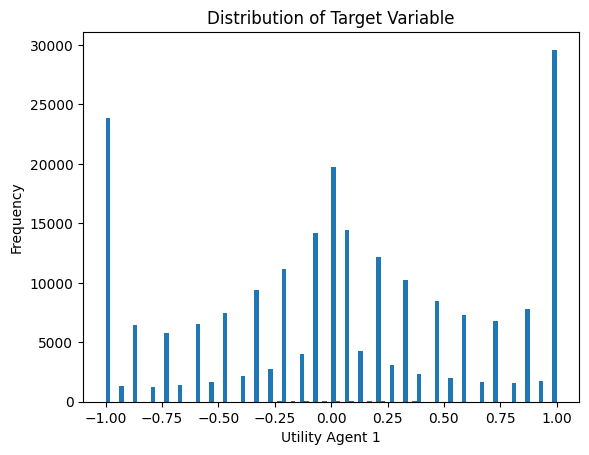

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model


Fold 1
[50]	valid_0's rmse: 0.46664
[100]	valid_0's rmse: 0.451265
[150]	valid_0's rmse: 0.443868
[200]	valid_0's rmse: 0.440451
[250]	valid_0's rmse: 0.436059
[300]	valid_0's rmse: 0.433459
[350]	valid_0's rmse: 0.431259
[400]	valid_0's rmse: 0.42994
[450]	valid_0's rmse: 0.428735
[500]	valid_0's rmse: 0.427513
[550]	valid_0's rmse: 0.426814
[600]	valid_0's rmse: 0.426175
[650]	valid_0's rmse: 0.425487
[700]	valid_0's rmse: 0.424953
[750]	valid_0's rmse: 0.424541
[800]	valid_0's rmse: 0.424007
[850]	valid_0's rmse: 0.423549
[900]	valid_0's rmse: 0.423425
[950]	valid_0's rmse: 0.423254
[1000]	valid_0's rmse: 0.422904
[1050]	valid_0's rmse: 0.422763
[1100]	valid_0's rmse: 0.42283
[1150]	valid_0's rmse: 0.422722
[1200]	valid_0's rmse: 0.422862
[1250]	valid_0's rmse: 0.422926
[1300]	valid_0's rmse: 0.423005
[1350]	valid_0's rmse: 0.423067
[1400]	valid_0's rmse: 0.422885
[1450]	valid_0's rmse: 0.422797
[1500]	valid_0's rmse: 0.422812
[1550]	valid_0's rmse: 0.422796
[1600]	valid_0's rmse: 0

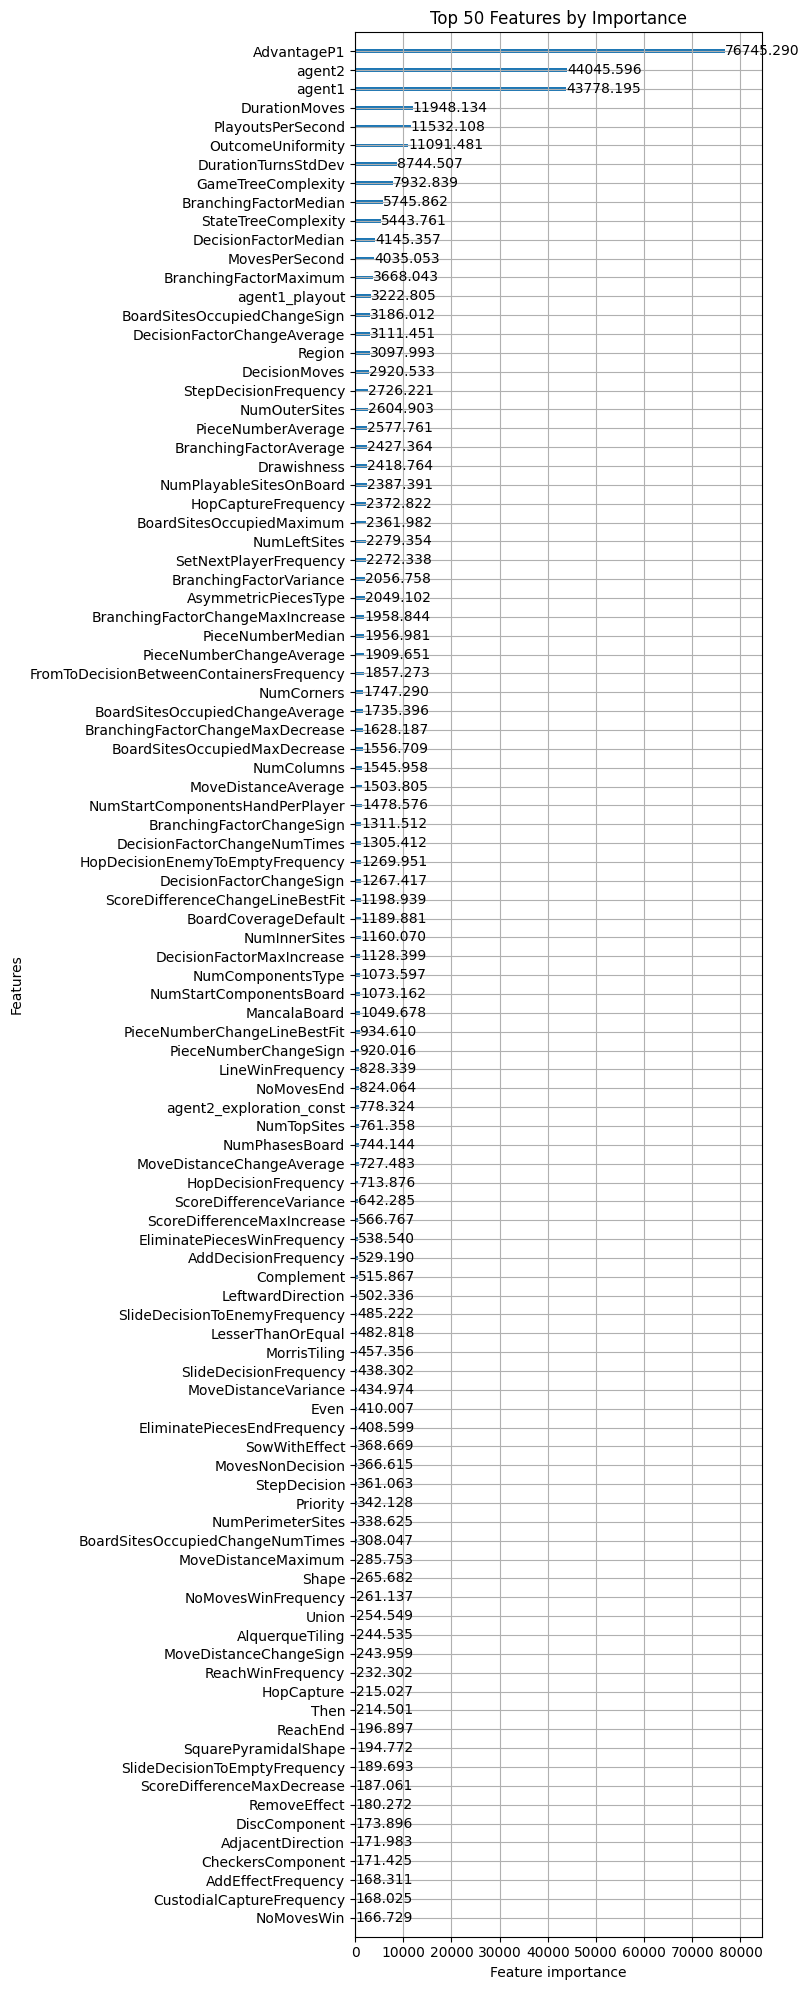

Fold 1 - RMSE: 0.4219082475638564
Fold 2
[50]	valid_0's rmse: 0.472192
[100]	valid_0's rmse: 0.460608
[150]	valid_0's rmse: 0.454688
[200]	valid_0's rmse: 0.450777
[250]	valid_0's rmse: 0.448045
[300]	valid_0's rmse: 0.445473
[350]	valid_0's rmse: 0.444227
[400]	valid_0's rmse: 0.44311
[450]	valid_0's rmse: 0.442479
[500]	valid_0's rmse: 0.441998
[550]	valid_0's rmse: 0.441194
[600]	valid_0's rmse: 0.44063
[650]	valid_0's rmse: 0.440282
[700]	valid_0's rmse: 0.440095
[750]	valid_0's rmse: 0.439879
[800]	valid_0's rmse: 0.439676
[850]	valid_0's rmse: 0.43926
[900]	valid_0's rmse: 0.439268
[950]	valid_0's rmse: 0.439174
[1000]	valid_0's rmse: 0.438954
[1050]	valid_0's rmse: 0.438876
[1100]	valid_0's rmse: 0.438705
[1150]	valid_0's rmse: 0.438386
[1200]	valid_0's rmse: 0.438124
[1250]	valid_0's rmse: 0.437963
[1300]	valid_0's rmse: 0.437789
[1350]	valid_0's rmse: 0.437748
[1400]	valid_0's rmse: 0.437511
[1450]	valid_0's rmse: 0.437447
[1500]	valid_0's rmse: 0.437417
[1550]	valid_0's rmse:

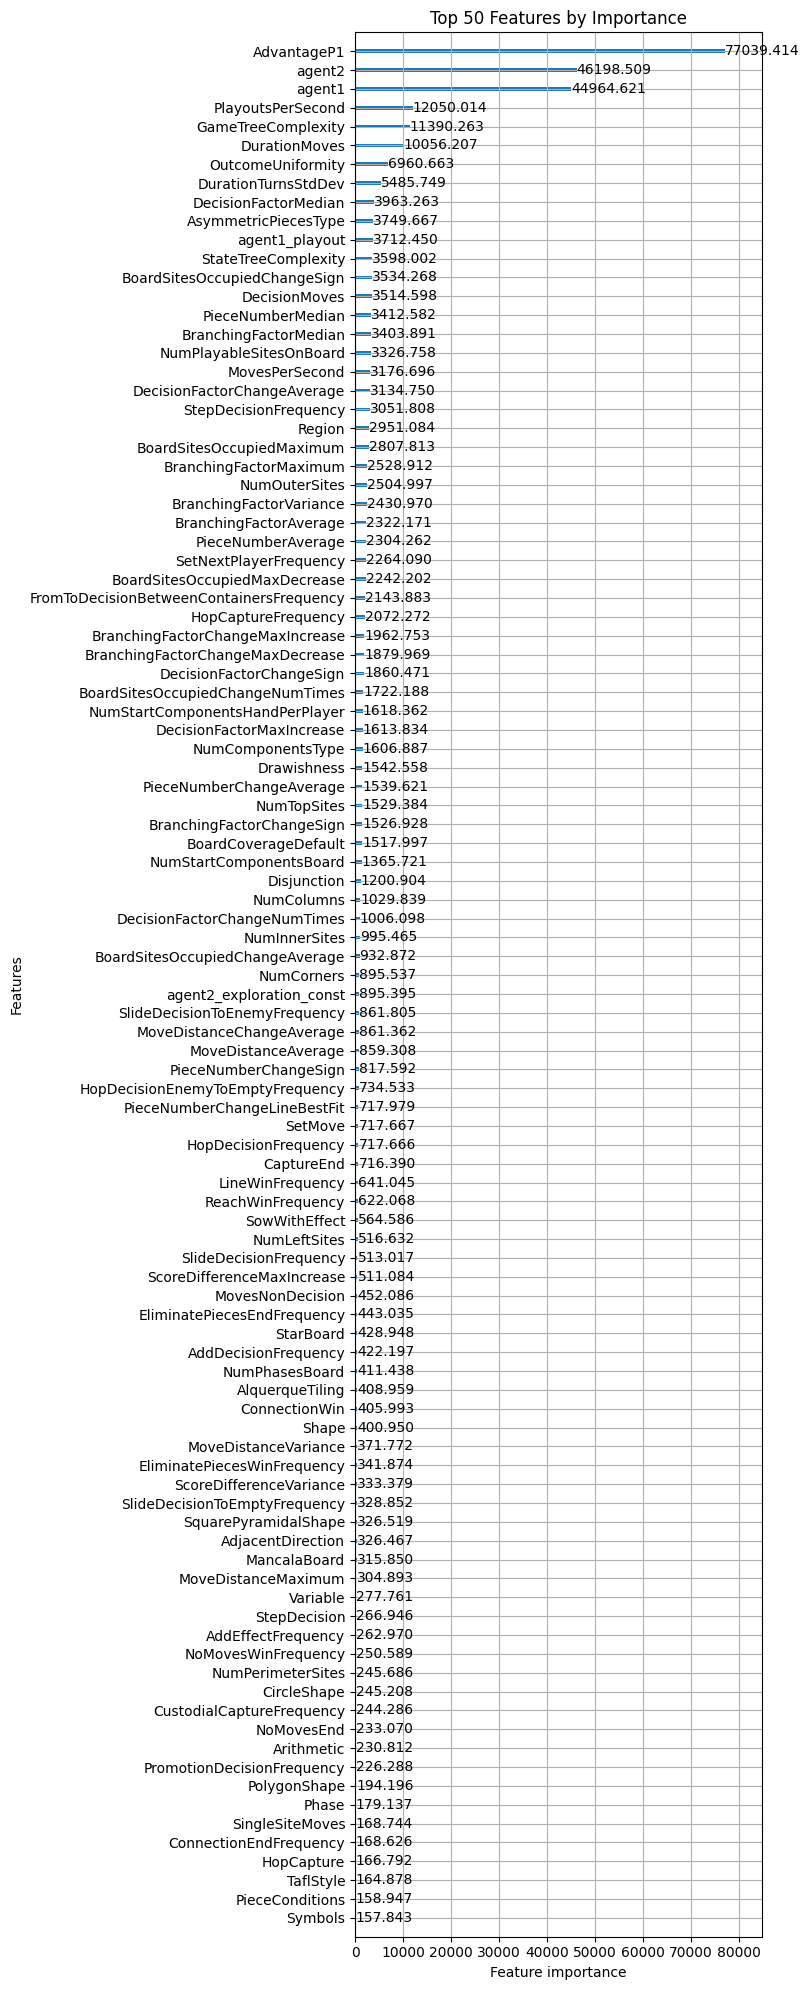

Fold 2 - RMSE: 0.43639051152707037
Fold 3
[50]	valid_0's rmse: 0.47872
[100]	valid_0's rmse: 0.466241
[150]	valid_0's rmse: 0.460081
[200]	valid_0's rmse: 0.455829
[250]	valid_0's rmse: 0.452276
[300]	valid_0's rmse: 0.449786
[350]	valid_0's rmse: 0.447048
[400]	valid_0's rmse: 0.445891
[450]	valid_0's rmse: 0.444211
[500]	valid_0's rmse: 0.443432
[550]	valid_0's rmse: 0.44317
[600]	valid_0's rmse: 0.442253
[650]	valid_0's rmse: 0.441539
[700]	valid_0's rmse: 0.441019
[750]	valid_0's rmse: 0.440733
[800]	valid_0's rmse: 0.440501
[850]	valid_0's rmse: 0.440205
[900]	valid_0's rmse: 0.440262
[950]	valid_0's rmse: 0.440119
[1000]	valid_0's rmse: 0.440043
[1050]	valid_0's rmse: 0.440129
[1100]	valid_0's rmse: 0.439896
[1150]	valid_0's rmse: 0.439957
[1200]	valid_0's rmse: 0.439912
[1250]	valid_0's rmse: 0.439818
[1300]	valid_0's rmse: 0.439793
[1350]	valid_0's rmse: 0.439528
[1400]	valid_0's rmse: 0.439444
[1450]	valid_0's rmse: 0.439307
[1500]	valid_0's rmse: 0.439206
[1550]	valid_0's rms

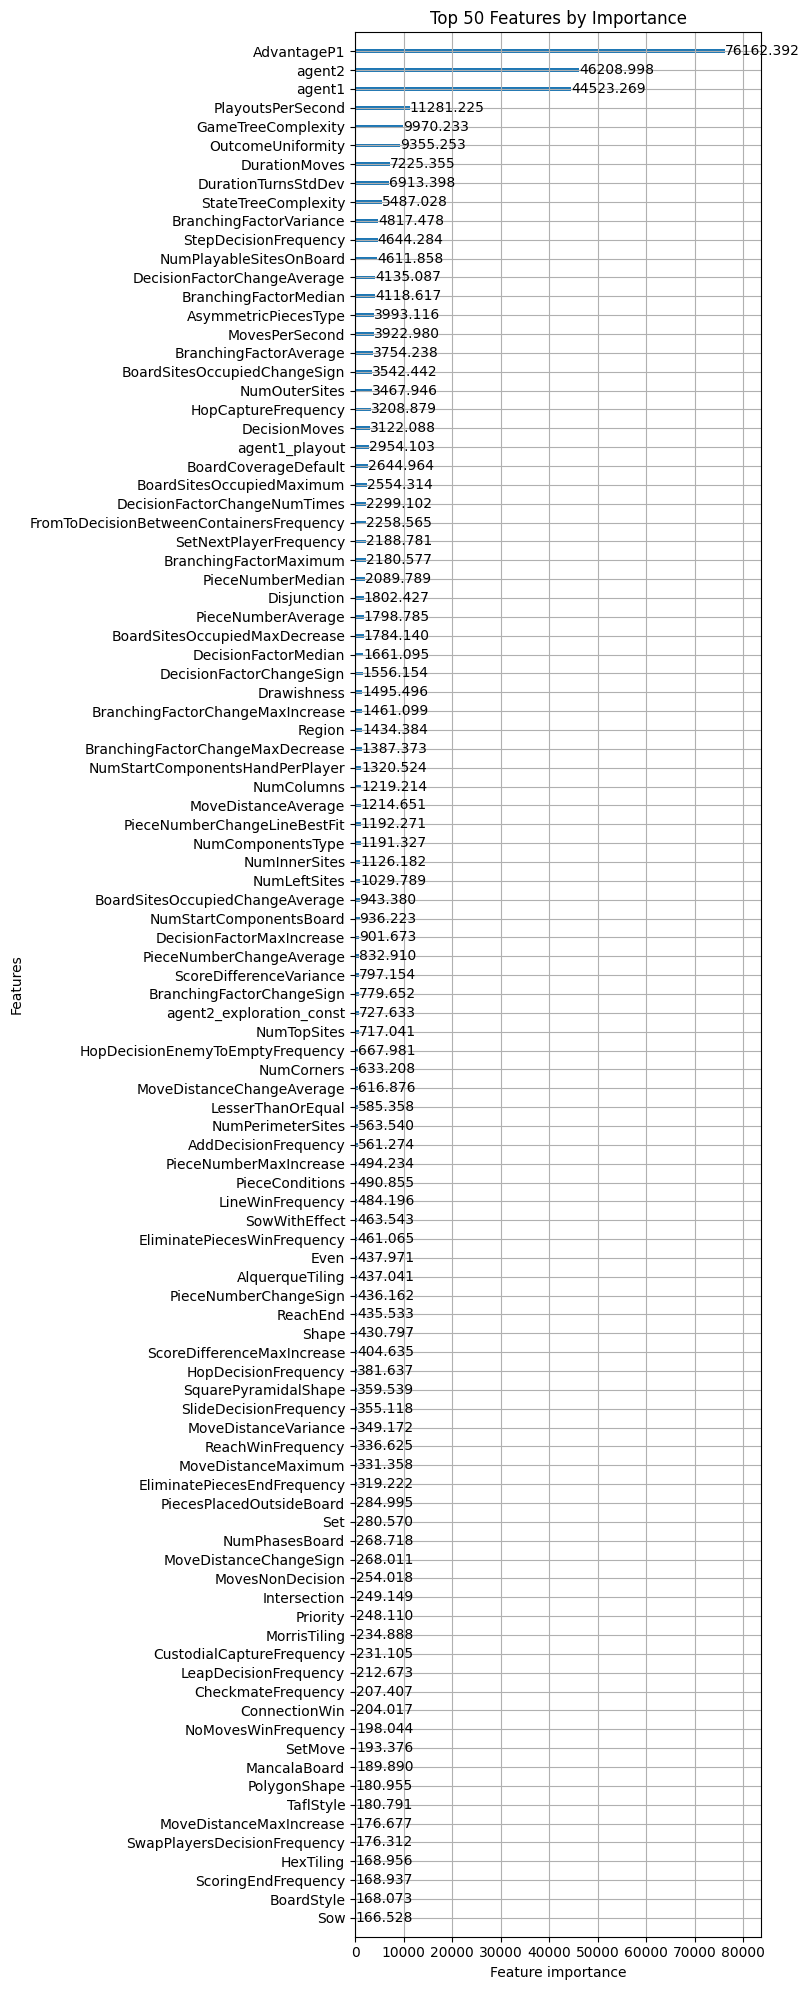

Fold 3 - RMSE: 0.43751915151749854
Fold 4
[50]	valid_0's rmse: 0.469673
[100]	valid_0's rmse: 0.45342
[150]	valid_0's rmse: 0.445123
[200]	valid_0's rmse: 0.440933
[250]	valid_0's rmse: 0.438527
[300]	valid_0's rmse: 0.436087
[350]	valid_0's rmse: 0.434424
[400]	valid_0's rmse: 0.43272
[450]	valid_0's rmse: 0.431668
[500]	valid_0's rmse: 0.430856
[550]	valid_0's rmse: 0.430084
[600]	valid_0's rmse: 0.429496
[650]	valid_0's rmse: 0.428747
[700]	valid_0's rmse: 0.428376
[750]	valid_0's rmse: 0.427887
[800]	valid_0's rmse: 0.427495
[850]	valid_0's rmse: 0.427055
[900]	valid_0's rmse: 0.426637
[950]	valid_0's rmse: 0.426366
[1000]	valid_0's rmse: 0.426055
[1050]	valid_0's rmse: 0.425792
[1100]	valid_0's rmse: 0.425602
[1150]	valid_0's rmse: 0.425544
[1200]	valid_0's rmse: 0.425397
[1250]	valid_0's rmse: 0.425215
[1300]	valid_0's rmse: 0.425063
[1350]	valid_0's rmse: 0.424837
[1400]	valid_0's rmse: 0.42488
[1450]	valid_0's rmse: 0.424482
[1500]	valid_0's rmse: 0.424467
[1550]	valid_0's rmse

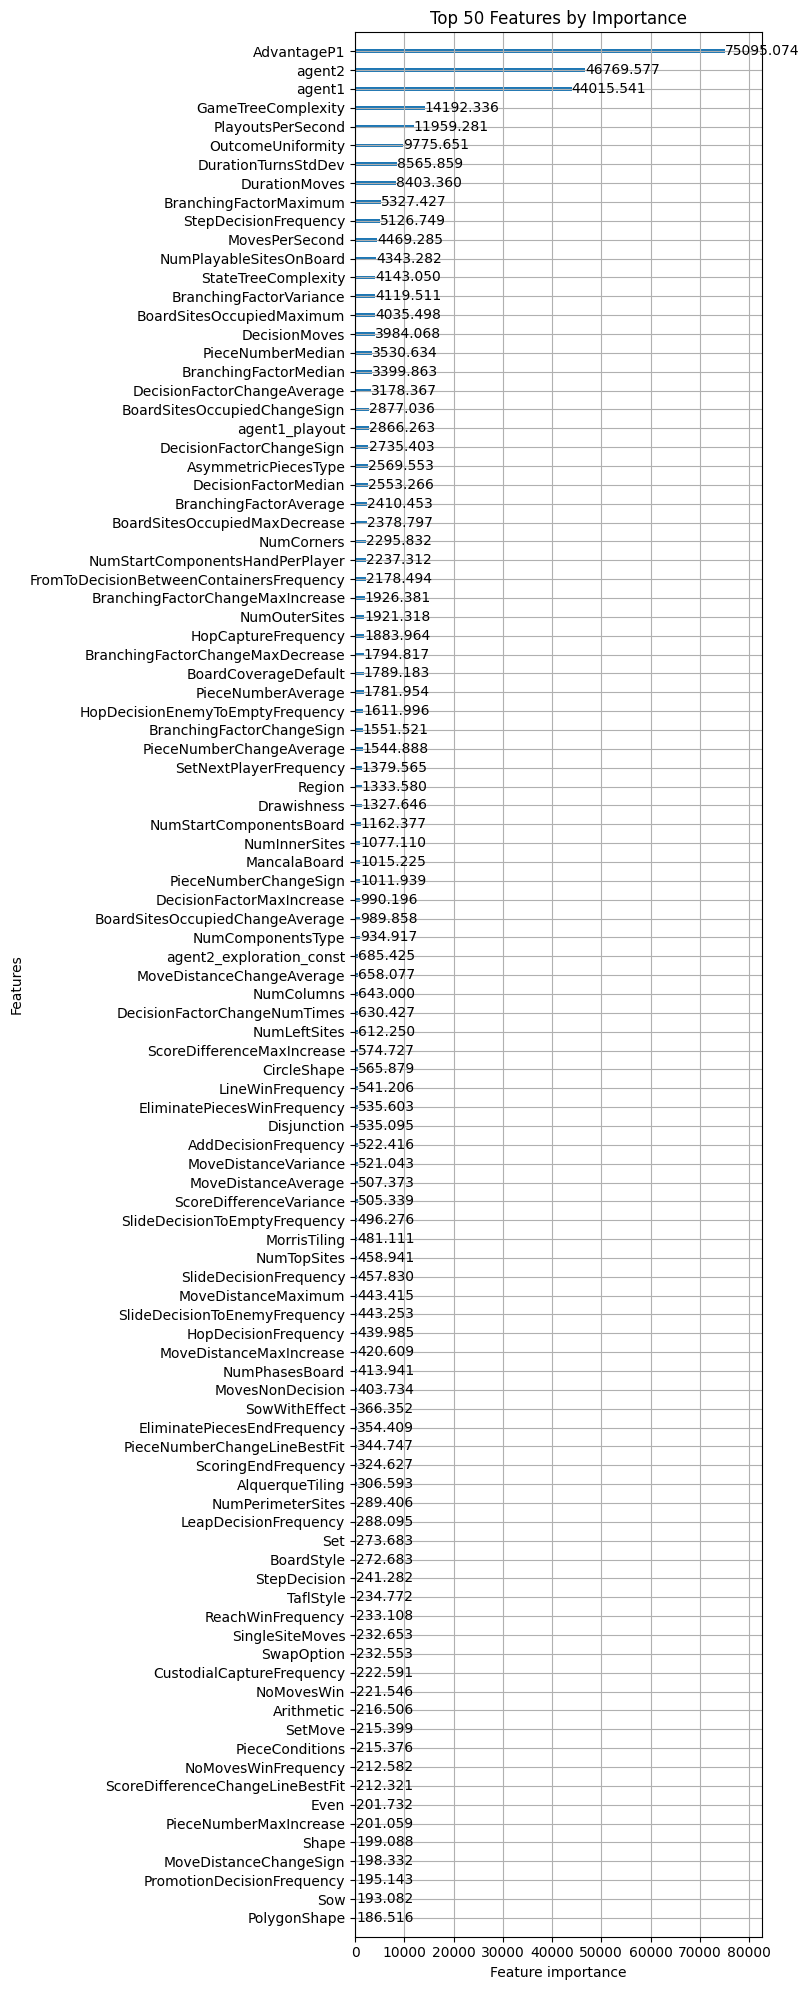

Fold 4 - RMSE: 0.42331703047368874
Fold 5
[50]	valid_0's rmse: 0.461509
[100]	valid_0's rmse: 0.446231
[150]	valid_0's rmse: 0.438944
[200]	valid_0's rmse: 0.434394
[250]	valid_0's rmse: 0.431824
[300]	valid_0's rmse: 0.429449
[350]	valid_0's rmse: 0.428098
[400]	valid_0's rmse: 0.426729
[450]	valid_0's rmse: 0.425227
[500]	valid_0's rmse: 0.424893
[550]	valid_0's rmse: 0.424273
[600]	valid_0's rmse: 0.423746
[650]	valid_0's rmse: 0.423242
[700]	valid_0's rmse: 0.422645
[750]	valid_0's rmse: 0.422379
[800]	valid_0's rmse: 0.421897
[850]	valid_0's rmse: 0.421455
[900]	valid_0's rmse: 0.421129
[950]	valid_0's rmse: 0.420866
[1000]	valid_0's rmse: 0.42054
[1050]	valid_0's rmse: 0.420421
[1100]	valid_0's rmse: 0.41998
[1150]	valid_0's rmse: 0.419972
[1200]	valid_0's rmse: 0.419938
[1250]	valid_0's rmse: 0.41976
[1300]	valid_0's rmse: 0.419579
[1350]	valid_0's rmse: 0.419573
[1400]	valid_0's rmse: 0.419459
[1450]	valid_0's rmse: 0.41947
[1500]	valid_0's rmse: 0.419438
[1550]	valid_0's rmse:

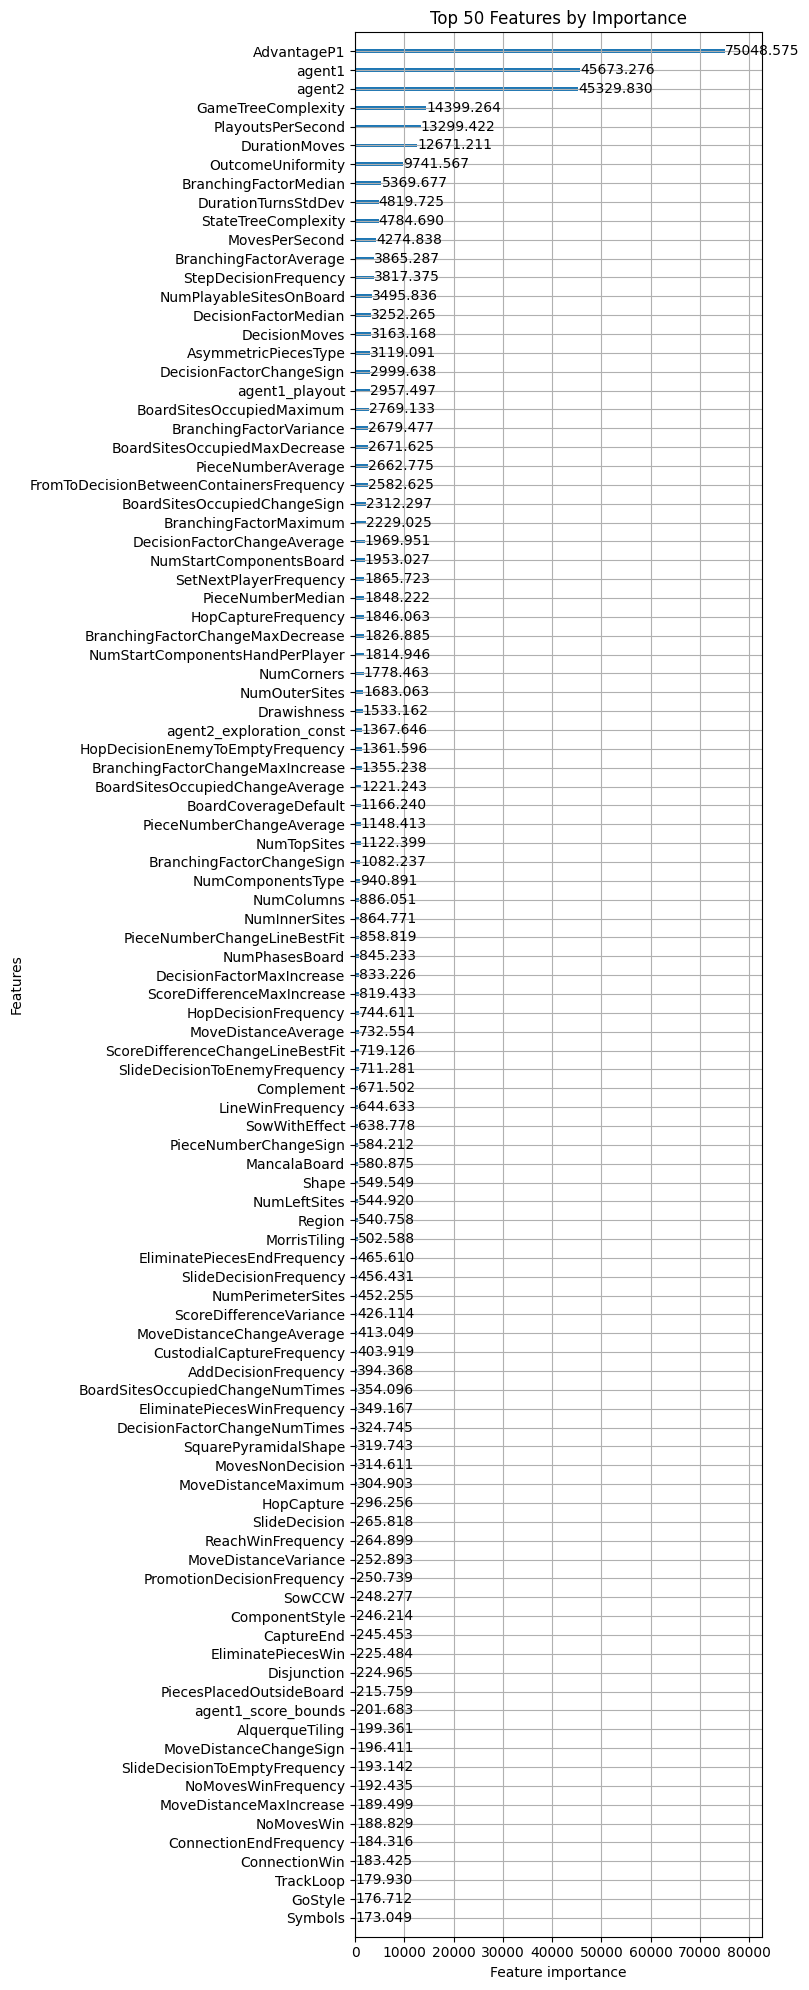

Fold 5 - RMSE: 0.4180132264989241
List of oof scores: [0.4219082475638564, 0.43639051152707037, 0.43751915151749854, 0.42331703047368874, 0.4180132264989241]
Average oof score: 0.42742963351620766


In [6]:
# Define the number of folds for cross-validation
num_folds = 5

# Shuffle the train dataset
# df_train = df_train.sample(frac=1, random_state=2112).reset_index(drop=True)

# Define the column for stratified or group k-fold
groups_col = 'GameRulesetName'
gkf = GroupKFold(n_splits=num_folds)
split_list = gkf.split(df_train, groups=df_train[groups_col])

target = 'utility_agent1'

# Define the parameters
params = {
    'objective': "regression",
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'max_depth': 10,
    'learning_rate': 0.1,
    'reg_alpha': 1e-1,
    'reg_lambda': 1e-1,
    'feature_fraction': 0.8,
    # 'bagging_fraction': 0.9,
    #'bagging_freq': 1,
    'verbose': -1,
    'seed': 2112,
}

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []
feature_importances = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
    y_train, y_val = X_train[target], X_val[target]
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(
        data=X_train[numerical_cols + categorical_cols],
        label=y_train,
        categorical_feature=categorical_cols,
        free_raw_data=True
    )
    val_data = lgb.Dataset(
        data=X_val[numerical_cols + categorical_cols],
        label=y_val,
        categorical_feature=categorical_cols,
        free_raw_data=True
    )

    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],
        callbacks=[
            lgb.log_evaluation(period=50),
            # lgb.early_stopping(stopping_rounds=100)
        ]
    )
    lgb.plot_importance(model, figsize=(8, 20), importance_type='gain', max_num_features=100)
    plt.title('Top 50 Features by Importance')
    plt.tight_layout()
    plt.show()
    
    # Save the trained model to the list
    trained_models.append(model)

    # predict on validation set
    y_pred = model.predict(X_val[numerical_cols + categorical_cols])
    y_pred = np.clip(y_pred, -1, 1)
    
    # Compute RMSE on scaled values
    rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_val
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# save oof predictions
oof.to_csv(path_results / 'oof_lightgbm.csv', index=False)


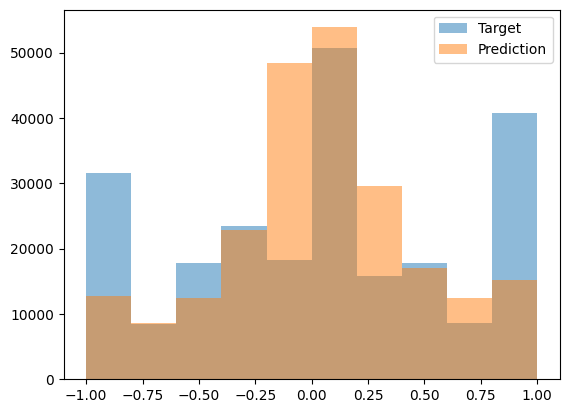

In [7]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [8]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [9]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [10]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

***